In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

%matplotlib inline

from session.sessions import selected_009266, selected_009265
from imports import *
from loading import load_session_data

from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Session data

In [65]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Controls: speed

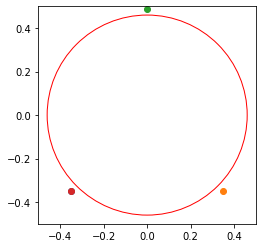

In [66]:
speakers_pos = {
    1: (-0.35, -0.35),  # before fireface
    2: ( 0.35, -0.35),  # before fireface
    3: ( 0, 0.49),
    5: (-0.35, -0.35)
}

fig, ax = plt.subplots(1, 1)
for num, pos in speakers_pos.items():
    ax.scatter(pos[0], pos[1])
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal')
ax.add_patch(plt.Circle((0, 0), 0.46, color='r', fill=False))

In [67]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
selected = sessions[:]
area = 'PPC'
m_type = 'norm'
#AEP_targets = ['P1', 'N1', 'P2', 'P3']
AEP_targets = ['P1', 'N1', 'P3']

speed_corr_mx = np.zeros([len(selected), len(AEP_targets)])  # change 4 to how many AEP comps.
speed_pval_mx = np.zeros([len(selected), len(AEP_targets)])  # change 4 to how many AEP comps.
dist_corr_mx  = np.zeros([len(selected), len(AEP_targets)])  # change 4 to how many AEP comps.
dist_pval_mx  = np.zeros([len(selected), len(AEP_targets)])  # change 4 to how many AEP comps.

for i, session in enumerate(selected):
    # load session data
    animal   = session.split('_')[0]
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    aeps_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        cfg          = json.loads(f['processed'].attrs['parameters'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        tl           = np.array(f['processed']['timeline'])

    # load AEP metrics
    AEP_metrics = {}
    with h5py.File(aeps_file, 'r') as f:
        metrics = {}
        for m in f[area]:
            metrics[m] = np.array(f[area][m])
        AEP_metrics[area] = metrics    
    
    # compute speed
    idxs_bgr = np.where(sound_events[:, 1] == 1)[0]  # BGR only
    speed_at_aeps = tl[sound_events[idxs_bgr][:, 2].astype(np.int32)][:, 3]
    
    for j, AEP_target in enumerate(AEP_targets):
        metric_vals = AEP_metrics[area]['%s_%s' % (AEP_target, m_type)][idxs_bgr]
        corr, pval = stats.pearsonr(speed_at_aeps, metric_vals)
        
        speed_corr_mx[i, j] = corr
        speed_pval_mx[i, j] = pval
        
    # compute instant distance to BGR speaker
    idxs_bgr = np.where(sound_events[:, 1] == 1)[0]  # BGR only
    bgr_ch = cfg['sound']['sounds']['background']['channels'][0]    
    sp_pos = speakers_pos[bgr_ch]
    tl_filt = tl[sound_events[idxs_bgr][:, 2].astype(np.int32)]
    dist_bgr = np.sqrt( (tl_filt[:, 1] - sp_pos[0])**2 + (tl_filt[:, 2] - sp_pos[1])**2 )
    
    for j, AEP_target in enumerate(AEP_targets):
        metric_vals = AEP_metrics[area]['%s_%s' % (AEP_target, m_type)][idxs_bgr]
        corr, pval = stats.pearsonr(dist_bgr, metric_vals)
        
        dist_corr_mx[i, j] = corr
        dist_pval_mx[i, j] = pval

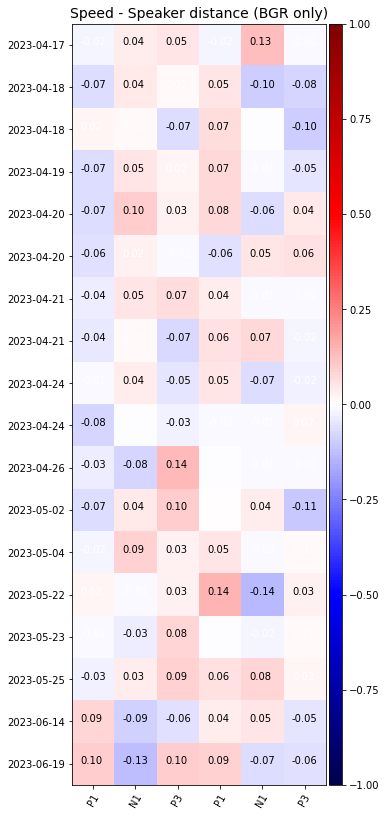

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

corr_mx = np.column_stack([speed_corr_mx, dist_corr_mx])
pval_mx = np.column_stack([speed_pval_mx, dist_pval_mx])

im = ax.imshow(corr_mx, cmap='seismic', vmin=-1, vmax=1)
ax.set_xticks(range(corr_mx.shape[1]))
ax.set_xticklabels(AEP_targets + AEP_targets, rotation=60)
ax.set_yticks(range(corr_mx.shape[0]))
_ = ax.set_yticklabels([x[-19:-9] for x in selected])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('Speed - Speaker distance (BGR only)', fontsize=14)
for p in range(corr_mx.shape[0]):
    for q in range(corr_mx.shape[1]):
        color = 'white' if pval_mx[p, q] > 0.05 else 'black'
        ax.text(q - 0.3, p, '%.2f' % corr_mx[p, q], color=color)